In [13]:
import os
import sys
sys.path.append('/home/kal/TF_models/bin/')
sys.path.append('/home/kal/K27act_models/convolution_model/')
sys.path.append('/home/kal/K27act_models/cg_model/')
sys.path.append('/home/thouis/basenji_embeddings')
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import tf_memory_limit
from zinb import ZINB
import seaborn as sns
import h5py
import matplotlib.pyplot as plt
from keras.utils import plot_model

import pandas as pd
import numpy as np
import itertools
import sequence
import ucscgenome
from tqdm import tqdm
import time
import datagen
import sequence
import helper
import viz_sequence
import pickle

from keras.models import Model
from keras.layers import Input, Dense, SpatialDropout1D, Conv1D, Lambda, Dropout
from keras.optimizers import RMSprop, SGD
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [2]:
#load in the DNA
genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')

In [3]:
# load in ATAC data
atac_path = '/home/kal/K27act_models/GM_data/ATAC/atac_average.hdf5'
atac = h5py.File(atac_path, 'r')

In [4]:
# load in (semi) preprocessed data
peaks_path = '/home/kal/K27act_models/GM_data/k27act_training_regions.bed'
peaks = pd.read_table(peaks_path, header=None)
peaks.columns='chr start end name score atac k27act nucs'.split()

In [5]:
# facts about the data
num_training_samples = len(peaks[(peaks.chr != 'chr8')])
print('{} training samples'.format(num_training_samples))

num_testing_samples = len(peaks[(peaks.chr == 'chr8') & (peaks.index%2 == 0)])
print('{} testing samples'.format(num_testing_samples))

num_validaiton_samples = len(peaks[(peaks.chr == 'chr8') & (peaks.index%2 == 1)])
print('{} validation samples'.format(num_validaiton_samples))

160363 training samples
3413 testing samples
3414 validation samples


In [6]:
# directory stuff
out_dir = '/home/kal/K27act_models/convolution_model/'
timestr = time.strftime("%Y%m%d_%H%M%S")
out_path = os.path.join(out_dir, timestr + '_conv_fold')
os.makedirs(out_path)
# make a file system
weights_path = os.path.join(out_path, 'intermediate_weights')
os.makedirs(weights_path)
history_path = os.path.join(out_path, 'history')
os.makedirs(history_path)

In [7]:
# MODEL
batch_size=32
seqs = Input(batch_shape=(batch_size, 1024, 5))

def add_RC(x):
    RC = K.concatenate([x[:, ::-1, :1], x[:, ::-1, 1:][::-1]], axis=2)
    return K.concatenate([x, RC], axis=0)
def add_RC_shape(s):
    return 2*s[0], s[1], s[2]

conv = Lambda(add_RC, name='add_rc', output_shape=add_RC_shape)(seqs)

for k, n in [[32, 3], [32, 32], [32, 3], [32, 3], [32,3]]:
    conv = Conv1D(k, n)(conv)
    conv = SpatialDropout1D(.05)(conv)

out = Dense(32)(conv) 
out = Dropout(.1)(out)
out = Dense(16)(out)
out = Dropout(.1)(out)
out = Dense(1)(out)

def max_by_direction(x):
    forward_max = K.max(x[:x.shape[0]//2, :, :], axis=1)
    reverse_max = K.max(x[x.shape[0]//2:, ::-1, :], axis=1)
    return K.maximum(forward_max, reverse_max)
def max_by_direction_shape(s):
    return s[0]//2, 1

predictions = Lambda(max_by_direction, name='max_by_direciton', output_shape=max_by_direction_shape)(out)
model = Model(inputs=seqs, outputs=predictions)

#plot model
plot_model(model, to_file=os.path.join(out_path, 'model.png'))

In [8]:
from keras.optimizers import RMSprop, SGD, Adam

opt_1 = Adam(beta_1=0.95, lr=0.0005, epsilon=.1)

    
    
model.compile(optimizer=opt_1, loss='mean_squared_error') 

early_stop = EarlyStopping(monitor='val_loss', patience=100)
filepath = os.path.join(weights_path, 'weights-1-{epoch:02d}-{val_loss:.3f}.hdf5')
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

losses_1 = model.fit_generator(datagen.batch_gen(peaks, mode='train'), steps_per_epoch=num_training_samples//batch_size, 
                             epochs=20, callbacks=[early_stop, checkpoint], validation_data=datagen.batch_gen(peaks,mode='val'), 
                             validation_steps=num_validaiton_samples//batch_size, verbose=2)

# drop learning rate
opt_2 = Adam(beta_1=0.95, lr=0.00005, epsilon=.001)
model.compile(optimizer=opt_2, loss='mean_squared_error') 

filepath = os.path.join(weights_path, 'weights-2-{epoch:02d}-{val_loss:.3f}.hdf5')
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

losses_2 = model.fit_generator(datagen.batch_gen(peaks, mode='train'), steps_per_epoch=num_training_samples//batch_size, 
                             epochs=20, callbacks=[early_stop, checkpoint], validation_data=datagen.batch_gen(peaks,mode='val'), 
                             validation_steps=num_validaiton_samples//batch_size, verbose=2)


# drop it again
opt_3 = Adam(beta_1=0.95, lr=0.000005, epsilon=.00001)
model.compile(optimizer=opt_3, loss='mean_squared_error') 

filepath = os.path.join(weights_path, 'weights-3-{epoch:02d}-{val_loss:.3f}.hdf5')
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

losses_3 = model.fit_generator(datagen.batch_gen(peaks, mode='train'), steps_per_epoch=num_training_samples//batch_size, 
                             epochs=20, callbacks=[early_stop, checkpoint], validation_data=datagen.batch_gen(peaks,mode='val'), 
                             validation_steps=num_validaiton_samples//batch_size, verbose=2)


Epoch 1/20
 - 386s - loss: 478.9945 - val_loss: 261.1459

Epoch 00001: val_loss improved from inf to 261.14595, saving model to /home/kal/K27act_models/convolution_model/20180706_125053_conv_fold/intermediate_weights/weights-1-01-261.146.hdf5
Epoch 2/20
 - 414s - loss: 194.5600 - val_loss: 62.4169

Epoch 00002: val_loss improved from 261.14595 to 62.41694, saving model to /home/kal/K27act_models/convolution_model/20180706_125053_conv_fold/intermediate_weights/weights-1-02-62.417.hdf5
Epoch 3/20
 - 412s - loss: 59.4479 - val_loss: 27.4387

Epoch 00003: val_loss improved from 62.41694 to 27.43867, saving model to /home/kal/K27act_models/convolution_model/20180706_125053_conv_fold/intermediate_weights/weights-1-03-27.439.hdf5
Epoch 4/20
 - 418s - loss: 21.7081 - val_loss: 11.6398

Epoch 00004: val_loss improved from 27.43867 to 11.63983, saving model to /home/kal/K27act_models/convolution_model/20180706_125053_conv_fold/intermediate_weights/weights-1-04-11.640.hdf5
Epoch 5/20
 - 412s - lo

In [10]:
# final save
model.save(os.path.join(out_path, 'final_model.h5'))

In [22]:
loss_list = [losses_1, losses_2, losses_3]
losses=dict()
for key in losses_1.history:
    data_group=list()
    for loss_obj in loss_list:
        data_group.append(loss_obj.history[key])
    losses[key] = np.asarray(data_group).flatten()

In [23]:
# write out history
pickle.dump(losses, open(os.path.join(history_path, 'history.pk'), 'wb'))

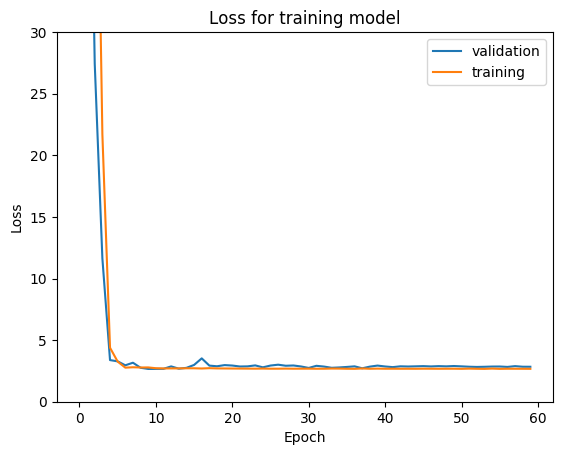

In [28]:
# look at loss
plt.plot(losses['val_loss'], label='validation')
plt.plot(losses['loss'], label='training')
plt.title('Loss for training model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim((0, 30))
plt.legend()
plt.show()